In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

In [53]:
# Load Dataset
app_train = pd.read_csv("application_train.csv")
app_test = pd.read_csv("application_test.csv")
print("Train shape:", app_train.shape)
print("Test shape:", app_test.shape)

Train shape: (307511, 122)
Test shape: (48744, 121)


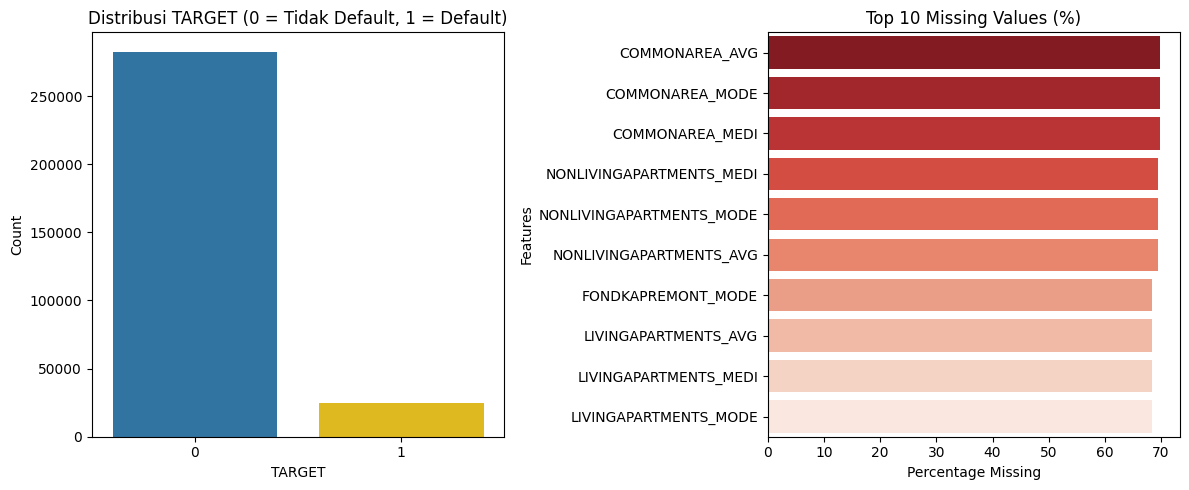

Top 10 Missing Values (Detail):


,Feature,Missing (%)
0,COMMONAREA_AVG,69.872297
1,COMMONAREA_MODE,69.872297
2,COMMONAREA_MEDI,69.872297
3,NONLIVINGAPARTMENTS_MEDI,69.432963
4,NONLIVINGAPARTMENTS_MODE,69.432963
5,NONLIVINGAPARTMENTS_AVG,69.432963
6,FONDKAPREMONT_MODE,68.386172
7,LIVINGAPARTMENTS_AVG,68.354953
8,LIVINGAPARTMENTS_MEDI,68.354953
9,LIVINGAPARTMENTS_MODE,68.354953


In [61]:
# Exploratory Data Analysis (EDA)
# Hitung Missing Values
missing = app_train.isnull().mean().sort_values(ascending=False) * 100
missing_top10 = missing.head(10).reset_index()
missing_top10.columns = ["Feature", "Missing (%)"]

# Plot Distribusi Target + Missing
plt.figure(figsize=(12,5))

# Distribusi TARGET
plt.subplot(1,2,1)
sns.countplot(x="TARGET", data=app_train, palette=["#1f77b4", "#ffcc00"], hue="TARGET", legend=False)
plt.title("Distribusi TARGET (0 = Tidak Default, 1 = Default)")
plt.xlabel("TARGET")
plt.ylabel("Count")

# Missing Values Top 10
plt.subplot(1,2,2)
sns.barplot(x="Missing (%)", y="Feature", data=missing_top10, palette="Reds_r", hue="Feature", legend=False)
plt.title("Top 10 Missing Values (%)")
plt.xlabel("Percentage Missing")
plt.ylabel("Features")

plt.tight_layout()
plt.show()

# === Tampilkan tabel detail ===
print("Top 10 Missing Values (Detail):")
display(missing_top10)

In [44]:
# Feature Engineering
# Single-table (dari application_train)
app_train["CREDIT_INCOME_RATIO"] = app_train["AMT_CREDIT"] / app_train["AMT_INCOME_TOTAL"]
app_test["CREDIT_INCOME_RATIO"] = app_test["AMT_CREDIT"] / app_test["AMT_INCOME_TOTAL"]

app_train["ANNUITY_INCOME_RATIO"] = app_train["AMT_ANNUITY"] / app_train["AMT_INCOME_TOTAL"]
app_test["ANNUITY_INCOME_RATIO"] = app_test["AMT_ANNUITY"] / app_test["AMT_INCOME_TOTAL"]

app_train["CREDIT_TERM"] = app_train["AMT_ANNUITY"] / app_train["AMT_CREDIT"]
app_test["CREDIT_TERM"] = app_test["AMT_ANNUITY"] / app_test["AMT_CREDIT"]

app_train["EMPLOYED_TO_AGE_RATIO"] = app_train["DAYS_EMPLOYED"] / app_train["DAYS_BIRTH"]
app_test["EMPLOYED_TO_AGE_RATIO"] = app_test["DAYS_EMPLOYED"] / app_test["DAYS_BIRTH"]

# Multi-table (contoh dari bureau.csv)
bureau = pd.read_csv("bureau.csv")
bureau_agg = bureau.groupby("SK_ID_CURR").agg({
    "AMT_CREDIT_SUM": ["mean", "max", "sum"],
    "AMT_CREDIT_SUM_DEBT": ["mean", "sum"],
    "CREDIT_DAY_OVERDUE": ["mean", "max"]
})

bureau_agg.columns = [
    "BUREAU_CREDIT_MEAN", "BUREAU_CREDIT_MAX", "BUREAU_CREDIT_SUM",
    "BUREAU_DEBT_MEAN", "BUREAU_DEBT_SUM",
    "BUREAU_OVERDUE_MEAN", "BUREAU_OVERDUE_MAX"
]
bureau_agg = bureau_agg.reset_index()

app_train = app_train.merge(bureau_agg, on="SK_ID_CURR", how="left")
app_test = app_test.merge(bureau_agg, on="SK_ID_CURR", how="left")

print("Train shape after FE:", app_train.shape)
print("Test shape after FE:", app_test.shape)

Train shape after FE: (307511, 123)
Test shape after FE: (48744, 122)


In [17]:
# Pilih beberapa kolom original + hasil FE untuk ditampilkan
fe_columns = [
    "SK_ID_CURR", "AMT_CREDIT", "AMT_INCOME_TOTAL", "AMT_ANNUITY",
    "DAYS_BIRTH", "DAYS_EMPLOYED",
    "CREDIT_INCOME_RATIO", "ANNUITY_INCOME_RATIO", "CREDIT_TERM", "EMPLOYED_TO_AGE_RATIO",
    "BUREAU_CREDIT_MEAN", "BUREAU_DEBT_SUM", "BUREAU_OVERDUE_MAX"
]

# Tampilkan 5 baris pertama
app_train[fe_columns].head().round(2)

,SK_ID_CURR,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,CREDIT_TERM,EMPLOYED_TO_AGE_RATIO,BUREAU_CREDIT_MEAN,BUREAU_DEBT_SUM,BUREAU_OVERDUE_MAX
0,100002,406597.5,202500.0,24700.5,-9461,-637,2.01,0.12,0.06,0.07,108131.95,245781.0,0.0
1,100003,1293502.5,270000.0,35698.5,-16765,-1188,4.79,0.13,0.03,0.07,254350.12,0.0,0.0
2,100004,135000.0,67500.0,6750.0,-19046,-225,2.00,0.10,0.05,0.01,94518.90,0.0,0.0
3,100006,312682.5,135000.0,29686.5,-19005,-3039,2.32,0.22,0.09,0.16,NaN,NaN,NaN
4,100007,513000.0,121500.0,21865.5,-19932,-3038,4.22,0.18,0.04,0.15,146250.00,0.0,0.0


In [18]:
# Preprocessing
# Drop kolom dengan missing value > 60%
missing = app_train.isnull().mean()
cols_to_drop = missing[missing > 0.6].index
app_train = app_train.drop(columns=cols_to_drop)
app_test = app_test.drop(columns=cols_to_drop)

# Pisahkan target & fitur
y = app_train["TARGET"]
X = app_train.drop(columns=["TARGET", "SK_ID_CURR"])
X_test_final = app_test.drop(columns=["SK_ID_CURR"])

# Imputasi missing values
# Numeric → median
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X_test_final[num_cols] = X_test_final[num_cols].fillna(X_test_final[num_cols].median())

# Categorical → mode
cat_cols = X.select_dtypes(include=["object"]).columns
for col in cat_cols:
    mode_val = X[col].mode()[0]
    X[col] = X[col].fillna(mode_val)
    X_test_final[col] = X_test_final[col].fillna(mode_val)

# Encode categorical
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape (final):", X_test_scaled.shape)

Train set shape: (246008, 114)
Validation set shape: (61503, 114)
Test set shape (final): (48744, 114)


=== Logistic Regression ===
ROC-AUC: 0.7489759563183752
Confusion Matrix - Logistic Regression
 [[39036 17502]
 [ 1597  3368]]


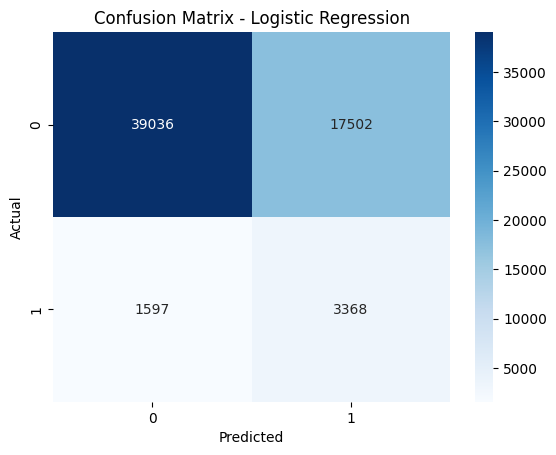


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503



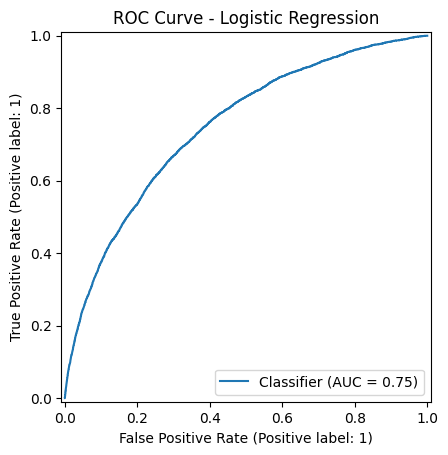

In [19]:
# Modeling & Evaluation - Logistic Regression
# Training Logistic
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train, y_train)

# Prediksi probabilitas
y_pred_lr = log_reg.predict_proba(X_val)[:, 1]

# Prediksi kelas (0/1)
y_pred_class_lr = (y_pred_lr > 0.5).astype(int)

#  Evaluasi
print("=== Logistic Regression ===")

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_val, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_val, y_pred_class_lr)
print("Confusion Matrix - Logistic Regression\n", cm_lr)

sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_pred_class_lr))

# ROC Curve
RocCurveDisplay.from_predictions(y_val, y_pred_lr)
plt.title("ROC Curve - Logistic Regression")
plt.show()

=== Random Forest ===
ROC-AUC: 0.7381792983157741
Confusion Matrix - Random Forest
 [[56525    13]
 [ 4942    23]]


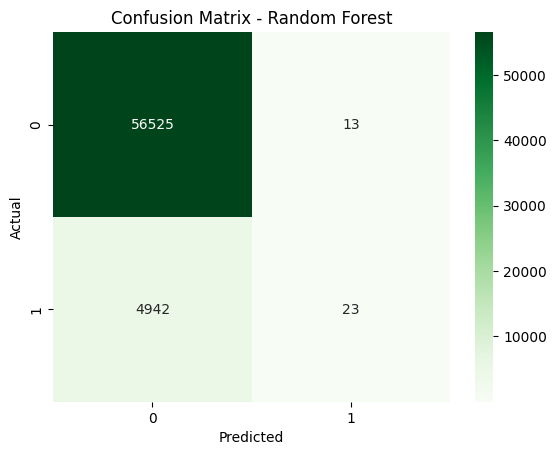


Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.64      0.00      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.78      0.50      0.48     61503
weighted avg       0.90      0.92      0.88     61503



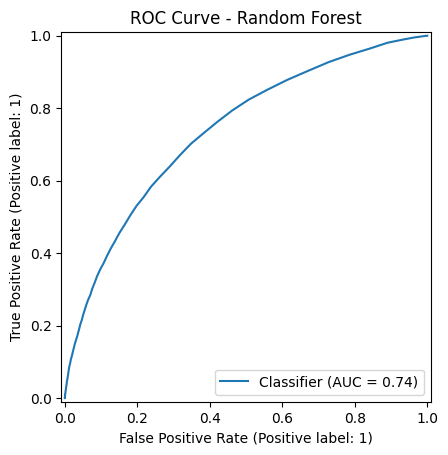

In [20]:
# Random Forest
# Training
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Prediksi probabilitas
y_pred_rf = rf.predict_proba(X_val)[:, 1]

# Prediksi kelas (0/1)
y_pred_class_rf = (y_pred_rf > 0.5).astype(int)

# Evaluasi
print("=== Random Forest ===")
print("ROC-AUC:", roc_auc_score(y_val, y_pred_rf))

cm_rf = confusion_matrix(y_val, y_pred_class_rf)
print("Confusion Matrix - Random Forest\n", cm_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n", classification_report(y_val, y_pred_class_rf))

RocCurveDisplay.from_predictions(y_val, y_pred_rf)
plt.title("ROC Curve - Random Forest")
plt.show()

=== XGBoost ===
ROC-AUC: 0.7693550545209868
Confusion Matrix - XGBoost
 [[43008 13530]
 [ 1821  3144]]


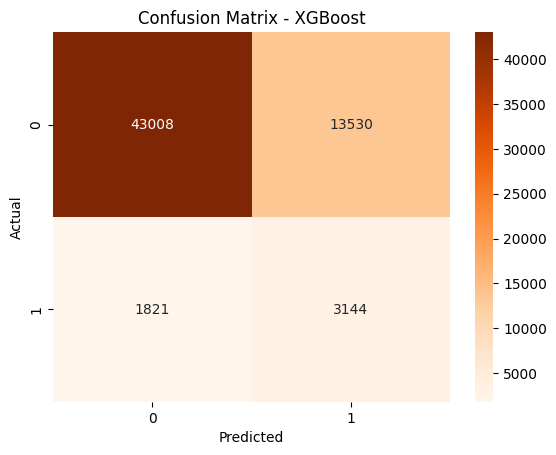


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.76      0.85     56538
           1       0.19      0.63      0.29      4965

    accuracy                           0.75     61503
   macro avg       0.57      0.70      0.57     61503
weighted avg       0.90      0.75      0.80     61503



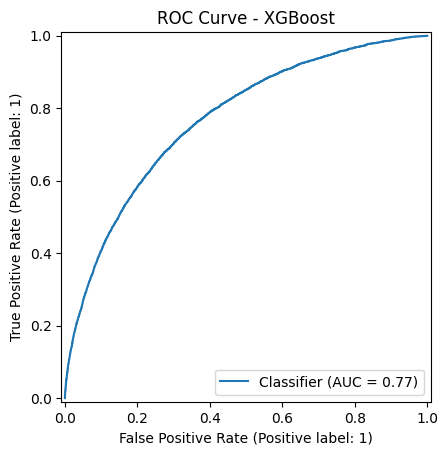

In [46]:
# XGBoost
# Training
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=10,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train, y_train)

# Prediksi probabilitas
y_pred_xgb = xgb.predict_proba(X_val)[:, 1]

# Prediksi kelas (0/1)
y_pred_class_xgb = (y_pred_xgb > 0.5).astype(int)

# Evaluasi
print("=== XGBoost ===")
print("ROC-AUC:", roc_auc_score(y_val, y_pred_xgb))

cm_xgb = confusion_matrix(y_val, y_pred_class_xgb)
print("Confusion Matrix - XGBoost\n", cm_xgb)

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges",
            xticklabels=[0,1], yticklabels=[0,1])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:\n", classification_report(y_val, y_pred_class_xgb))

RocCurveDisplay.from_predictions(y_val, y_pred_xgb)
plt.title("ROC Curve - XGBoost")
plt.show()

Top 10 Features - Random Forest:
                     Feature  Importance
39             EXT_SOURCE_2    0.065633
40             EXT_SOURCE_3    0.062113
15               DAYS_BIRTH    0.032860
105             CREDIT_TERM    0.032150
106   EMPLOYED_TO_AGE_RATIO    0.029777
38             EXT_SOURCE_1    0.028901
18          DAYS_ID_PUBLISH    0.028278
76   DAYS_LAST_PHONE_CHANGE    0.027012
17        DAYS_REGISTRATION    0.026877
16            DAYS_EMPLOYED    0.026076


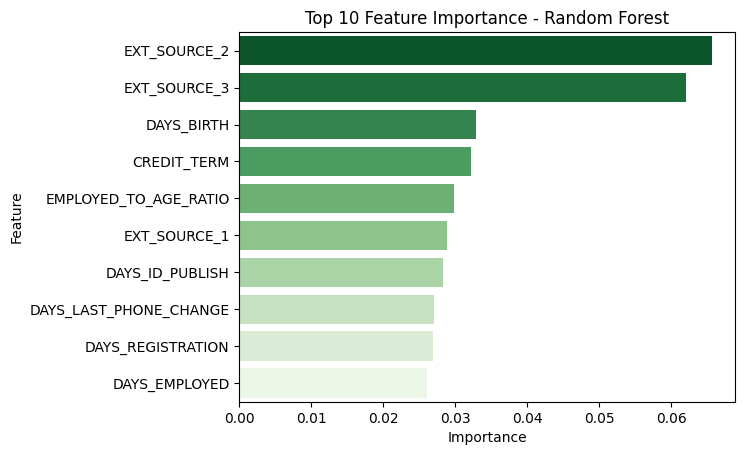

In [47]:
# Feature Importance - Random Forest
importances_rf = rf.feature_importances_
feat_names = X.columns

rf_feat_imp = pd.DataFrame({"Feature": feat_names, "Importance": importances_rf})
rf_feat_imp = rf_feat_imp.sort_values(by="Importance", ascending=False).head(10)

print("Top 10 Features - Random Forest:\n", rf_feat_imp)

sns.barplot(data=rf_feat_imp, x="Importance", y="Feature", hue="Feature", palette="Greens_r", legend=False)
plt.title("Top 10 Feature Importance - Random Forest")
plt.show()

Top 10 Features - XGBoost:
                  Feature  Importance
39          EXT_SOURCE_2    0.076457
40          EXT_SOURCE_3    0.074408
11   NAME_EDUCATION_TYPE    0.035540
1            CODE_GENDER    0.031471
78       FLAG_DOCUMENT_3    0.026827
10      NAME_INCOME_TYPE    0.023308
38          EXT_SOURCE_1    0.021409
2           FLAG_OWN_CAR    0.021313
0     NAME_CONTRACT_TYPE    0.018524
105          CREDIT_TERM    0.017449


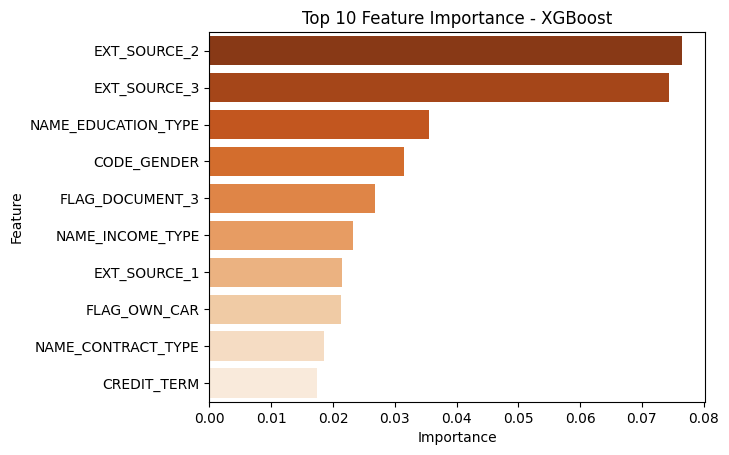

In [48]:
# Feature Importance - XGBoost
importances_xgb = xgb.feature_importances_

xgb_feat_imp = pd.DataFrame({"Feature": feat_names, "Importance": importances_xgb})
xgb_feat_imp = xgb_feat_imp.sort_values(by="Importance", ascending=False).head(10)

print("Top 10 Features - XGBoost:\n", xgb_feat_imp)

sns.barplot(data=xgb_feat_imp, x="Importance", y="Feature", hue="Feature", palette="Oranges_r", legend=False)
plt.title("Top 10 Feature Importance - XGBoost")
plt.show()

In [49]:
# Load sample_submission.csv sebagai template
submission = pd.read_csv("sample_submission.csv")

# Prediksi probabilitas gagal bayar (kelas 1)
submission["TARGET"] = xgb.predict_proba(X_test_scaled)[:, 1]

# Simpan Feature Importance
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_
})
feat_imp.to_csv("feature_importance.csv", index=False)
print("✅ Feature importance saved as feature_importance.csv")

# Simpan submission file (sudah dibuat sebelumnya)
submission.to_csv("submission.csv", index=False)
print("✅ Submission file saved as submission.csv")

print(submission.head())

✅ Feature importance saved as feature_importance.csv
✅ Submission file saved as submission.csv
   SK_ID_CURR    TARGET
0      100001  0.248793
1      100005  0.510227
2      100013  0.102026
3      100028  0.272674
4      100038  0.550546
